# LOAD DATA

In [104]:
from google.colab import files
files.upload()  # Upload kaggle.json di sini

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"yuliantoaryaseta","key":"a6fa6b69246c8dc275ec2b3c6594245c"}'}

## Data

In [105]:
# Persiapan kredensial Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset from Kaggle
!kaggle datasets download -d utkarshsharma11r/student-mental-health-analysis -p /content/datasets --unzip

Dataset URL: https://www.kaggle.com/datasets/utkarshsharma11r/student-mental-health-analysis
License(s): CC0-1.0
  0% 0.00/10.5k [00:00<?, ?B/s]
100% 10.5k/10.5k [00:00<00:00, 26.5MB/s]


# IMPORT LIBRARY

In [106]:
!pip install langchain_community
!pip install replicate
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [107]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

# EXPLORATORY DATA ANALYSIS

In [108]:
df = "/content/datasets/Student Mental Health Analysis During Online Learning.csv"
df = pd.read_csv(df)

In [109]:
# Preview the data
df.head()

,Name,Gender,Age,Education Level,Screen Time (hrs/day),Sleep Duration (hrs),Physical Activity (hrs/week),Stress Level,Anxious Before Exams,Academic Performance Change
0,Aarav,Male,15,Class 8,7.1,8.9,9.3,Medium,No,Same
1,Meera,Female,25,MSc,3.3,5.0,0.2,Medium,No,Same
2,Ishaan,Male,20,BTech,9.5,5.4,6.2,Medium,No,Same
3,Aditya,Male,20,BA,10.8,5.6,5.5,High,Yes,Same
4,Anika,Female,17,Class 11,2.8,5.4,3.1,Medium,Yes,Same


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          1000 non-null   object 
 1   Gender                        1000 non-null   object 
 2   Age                           1000 non-null   int64  
 3   Education Level               1000 non-null   object 
 4   Screen Time (hrs/day)         1000 non-null   float64
 5   Sleep Duration (hrs)          1000 non-null   float64
 6   Physical Activity (hrs/week)  1000 non-null   float64
 7   Stress Level                  1000 non-null   object 
 8   Anxious Before Exams          1000 non-null   object 
 9   Academic Performance Change   1000 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 78.3+ KB


Cek nilai NaN disetiap kolom dan drop kolom "Name" pada dataset.

In [111]:
# Cek apakah ada nilai NaN di setiap kolom
nan_counts = df.isnull().sum()
print("Jumlah nilai NaN di setiap kolom:")
print(nan_counts)

# Drop kolom 'Name'
df.drop(columns=['Name'], inplace=True)

Jumlah nilai NaN di setiap kolom:
Name                            0
Gender                          0
Age                             0
Education Level                 0
Screen Time (hrs/day)           0
Sleep Duration (hrs)            0
Physical Activity (hrs/week)    0
Stress Level                    0
Anxious Before Exams            0
Academic Performance Change     0
dtype: int64


Mengacak data dan mengambil 500 baris pertama dari data sebagai data untuk dianalisis dan dikonversi ke string.

In [112]:
# Shuffle data dan ambil 500 baris pertama
shuffled_df = df.sample(frac=1, random_state=42).head(500)

# Konversi ke teks
table_text = shuffled_df.to_string(index=False)

In [113]:
# --- Statistik Deskriptif ---
print("Statistik Deskriptif Numerik:")
shuffled_df.describe()

Statistik Deskriptif Numerik:


,Age,Screen Time (hrs/day),Sleep Duration (hrs),Physical Activity (hrs/week)
count,500.000000,500.000000,500.000000,500.000000
mean,20.178000,7.025200,6.451800,5.100000
std,3.467906,2.952504,1.473553,2.920236
min,15.000000,2.000000,4.000000,0.000000
25%,17.000000,4.500000,5.100000,2.700000
50%,20.000000,7.100000,6.500000,5.200000
75%,23.000000,9.700000,7.700000,7.525000
max,26.000000,12.000000,9.000000,10.000000


In [114]:
print("\nStatistik Deskriptif Kategorikal:")
shuffled_df.describe(include='object')



Statistik Deskriptif Kategorikal:


,Gender,Education Level,Stress Level,Anxious Before Exams,Academic Performance Change
count,500,500,500,500,500
unique,3,11,3,2,3
top,Male,MTech,Medium,Yes,Same
freq,243,69,251,259,196


In [115]:
# --- Encoding Kolom Kategorikal untuk Korelasi ---
df_encoded = shuffled_df.copy()
categorical_cols = ['Stress Level', 'Gender', 'Academic Performance Change']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))


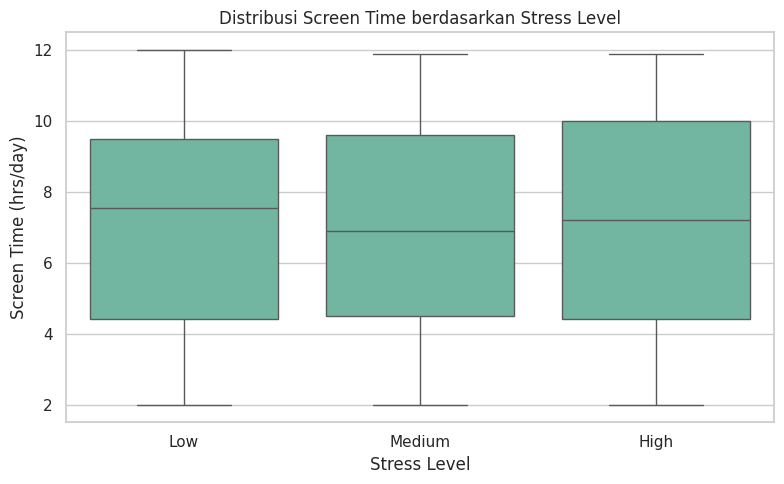

In [116]:
# --- Boxplot: Screen Time vs Stress Level ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='Stress Level', y='Screen Time (hrs/day)', data=shuffled_df)
plt.title('Distribusi Screen Time berdasarkan Stress Level')
plt.tight_layout()
plt.show()

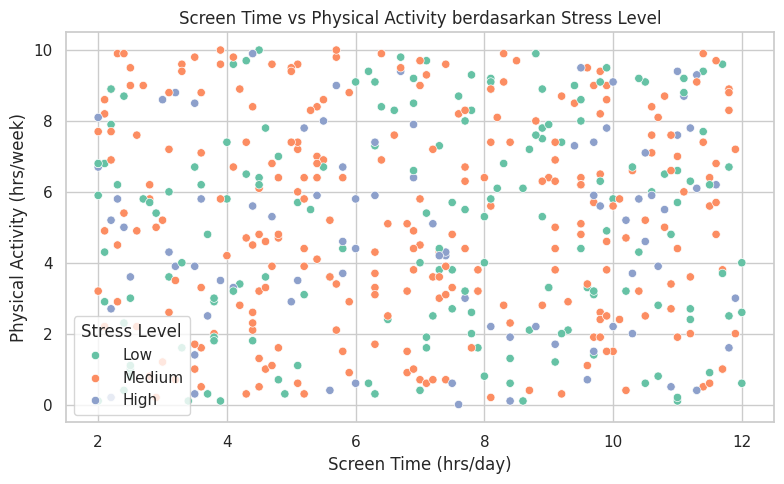

In [117]:
# --- Scatterplot: Screen Time vs Physical Activity ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='Screen Time (hrs/day)',
    y='Physical Activity (hrs/week)',
    hue='Stress Level',
    data=shuffled_df
)
plt.title('Screen Time vs Physical Activity berdasarkan Stress Level')
plt.tight_layout()
plt.show()

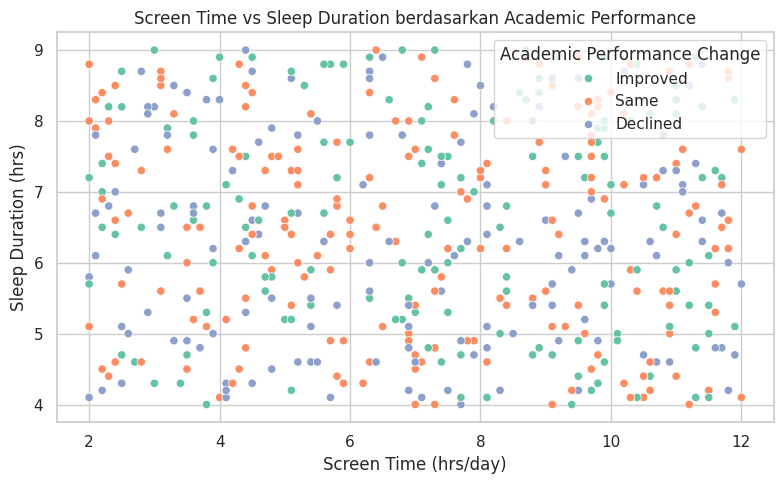

In [118]:
# --- Scatterplot: Screen Time vs Academic Performance Change (encoded) ---
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x='Screen Time (hrs/day)',
    y='Sleep Duration (hrs)',
    hue='Academic Performance Change',
    data=shuffled_df
)
plt.title('Screen Time vs Sleep Duration berdasarkan Academic Performance')
plt.tight_layout()
plt.show()

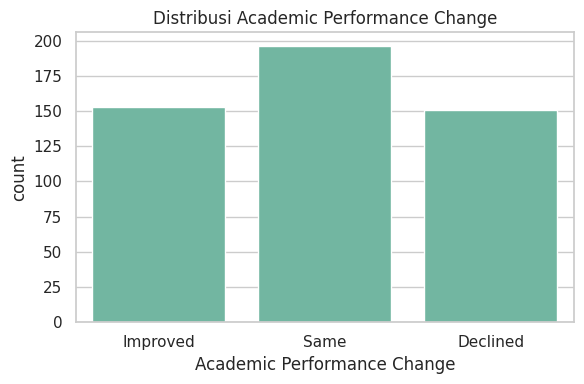

In [119]:
# --- Barplot: Academic Performance Change ---
plt.figure(figsize=(6, 4))
sns.countplot(x='Academic Performance Change', data=shuffled_df)
plt.title('Distribusi Academic Performance Change')
plt.tight_layout()
plt.show()

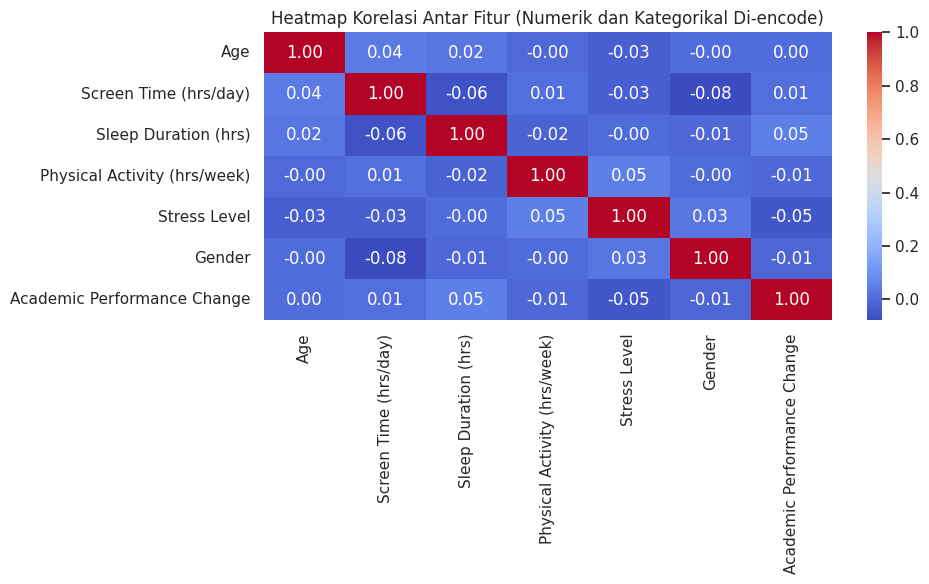

In [120]:

# Pilih hanya kolom numerik dan kolom kategorikal yang sudah di-encode
cols_to_use = ['Age', 'Screen Time (hrs/day)', 'Sleep Duration (hrs)', 'Physical Activity (hrs/week)'] + categorical_cols

# Buat subset dataframe untuk korelasi
df_corr = df_encoded[cols_to_use]

# Plot heatmap korelasi
plt.figure(figsize=(10, 6))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Antar Fitur (Numerik dan Kategorikal Di-encode)")
plt.tight_layout()
plt.show()

In [121]:
preview_lines = table_text.split('\n')[:10]  # ambil 10 baris pertama
preview_text = '\n'.join(preview_lines)
print(preview_text)

Gender  Age Education Level  Screen Time (hrs/day)  Sleep Duration (hrs)  Physical Activity (hrs/week) Stress Level Anxious Before Exams Academic Performance Change
  Male   22             BSc                    7.5                   5.3                           2.7          Low                   No                    Improved
  Male   15         Class 9                    8.0                   7.2                           4.0          Low                   No                        Same
  Male   17        Class 10                    5.1                   7.3                           9.6       Medium                   No                        Same
Female   16        Class 10                   10.4                   8.8                           3.2       Medium                  Yes                    Improved
  Male   19        Class 12                    3.1                   8.7                           7.2       Medium                   No                        Same
  Male   1

# ANALYSIS PROCESS WITH IBM GRANITE

Melakukan list dan eksplorasi dari setiap nilai yang unik(tidak duplikat) pada kolom fitur Gender, Age, Education Level, Stress Level, Anxious Before Exams, dan Academic Performance Change.

In [122]:
# Define refined prompt
refined_prompt = f"""
List every unique value in every feature in the Data except Screen Time (hrs/day), Sleep Duration (hrs), and  Physical Activity (hrs/week)
Data:
{table_text}
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt)

# Print the response
print("Student Well-being and Academic Performance Analysis:\n")
print(response)


Student Well-being and Academic Performance Analysis:

### Unique Values in Each Feature (excluding Screen Time (hrs/day), Sleep Duration (hrs), and Physical Activity (hrs/week)):

**Gender:**
- Male
- Female
- Other

**Age:**
- 15
- 16
- 17
- 18
- 19
- 20
- 21
- 22
- 23
- 24
- 25
- 26

**Education Level:**
- Class 8
- Class 9
- Class 10
- Class 11
- Class 12
- BSc
- MA
- MTech
- BTech
- MSc
- BA

**Stress Level:**
- Low
- Medium
- High

**Anxious Before Exams:**
- No
- Yes

**Academic Performance Change:**
- Improved
- Same
- Declined

This list includes all unique values found in the columns 'Gender', 'Age', 'Education Level', 'Stress Level', 'Anxious Before Exams', and 'Academic Performance Change' from the provided dataset, excluding 'Screen Time (hrs/day)', 'Sleep Duration (hrs)', and 'Physical Activity (hrs/week)'.


Melakukan list dan eksplorasi dari setiap nilai yang unik(tidak duplikat) pada kolom fitur Screen Time (hrs/day) dengan aturan rounded dan melihat berapa nilai minimal dan maksimalnya.

In [123]:
# Set model parameters for prompting with default values
parameters = {
 "top_k": 0,
 "top_p": 0,
 "max_tokens": 128,
 "min_tokens": 0,
 "random_seed": None,
 "repetition_penalty": 1.5,
 "stopping_criteria": "length (256 tokens)",
 "stopping_sequence": 256
}

# Define refined prompt
refined_prompt = f"""
You are given a dataset. Focus only on the following three numeric features:
- Screen Time (hrs/day)

Your task:
1. Apply this rounding rule to each value:
   - If the decimal is less than 0.5, round it down to the nearest whole number.
   - If the decimal is exactly 0.5, keep it as is (e.g., 6.5 remains 6.5).
   - If the decimal is greater than 0.5, round it up to the nearest whole number.

3. From the rounded values, return with no duplicates.

4. For each feature, show the following:
   - Rounded (unique): [list of unique rounded values]
   - Min: minimum value from the rounded list
   - Max: maximum value from the rounded list

Here is the dataset:
{table_text}
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt, parameters=parameters)

# Print the response
print("Rounded Unique Values with Min/Max for Numeric Features:\n")
print(response)


Rounded Unique Values with Min/Max for Numeric Features:

### Rounded Screen Time (unique values): [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

### Min: 2  
### Max: 15

The unique rounded values of "Screen Time (hrs/day)" from the dataset are 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, and 15. The minimum value is 2, and the maximum value is 15. Note that the original dataset contained various irrelevant columns which were ignored as per the instructions.


Melakukan list dan eksplorasi dari setiap nilai yang unik(tidak duplikat) pada kolom fitur Sleep Duration (hrs) dengan aturan rounded dan melihat berapa nilai minimal dan maksimalnya.

In [124]:
# Set model parameters for prompting with default values
parameters = {
 "top_k": 0,
 "top_p": 0,
 "max_tokens": 128,
 "min_tokens": 0,
 "random_seed": None,
 "repetition_penalty": 1.5,
 "stopping_criteria": "length (256 tokens)",
 "stopping_sequence": 256
}

# Define refined prompt
refined_prompt = f"""
You are given a dataset. Focus only on the following three numeric features:
- Sleep Duration (hrs)

Your task:
1. Apply this rounding rule to each value:
   - If the decimal is less than 0.5, round it down to the nearest whole number.
   - If the decimal is exactly 0.5, keep it as is (e.g., 6.5 remains 6.5).
   - If the decimal is greater than 0.5, round it up to the nearest whole number.

3. From the rounded values, return with no duplicates.

4. For each feature, show the following:
   - Rounded (unique): [list of unique rounded values]
   - Min: minimum value from the rounded list
   - Max: maximum value from the rounded list

Here is the dataset:
{table_text}
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt, parameters=parameters)

# Print the response
print("Rounded Unique Values with Min/Max for Numeric Features:\n")
print(response)


Rounded Unique Values with Min/Max for Numeric Features:

### Rounded Sleep Duration (unique):
[5, 4.5, 6, 7, 7.5, 7.3, 7.4, 7.6, 7.8, 7.9, 8, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9, 9.1, 9.2, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10, 10.0, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11, 11.0, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 12]

### Min:
5

### Max:
12


Melakukan list dan eksplorasi dari setiap nilai yang unik(tidak duplikat) pada kolom fitur Physical Activity (hrs/week) dengan aturan rounded dan melihat berapa nilai minimal dan maksimalnya.

In [125]:
# Set model parameters for prompting with default values
parameters = {
 "top_k": 0,
 "top_p": 0,
 "max_tokens": 256,
 "min_tokens": 0,
 "random_seed": None,
 "repetition_penalty": 1.5,
 "stopping_criteria": "length (256 tokens)",
 "stopping_sequence": 128
}

# Define refined prompt
refined_prompt = f"""
You are given a dataset. Focus only on the following three numeric features:
- Physical Activity (hrs/week)

Your task:
1. Apply this rounding rule to each value:
   - If the decimal is less than 0.5, round it down to the nearest whole number.
   - If the decimal is exactly 0.5, keep it as is (e.g., 6.5 remains 6.5).
   - If the decimal is greater than 0.5, round it up to the nearest whole number.

3. From the rounded values, return with no duplicates.

4. For each feature, show the following:
   - Rounded (unique): [list of unique rounded values]
   - Min: minimum value from the rounded list
   - Max: maximum value from the rounded list

Here is the dataset:
{table_text}
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt, parameters=parameters)

# Print the response
print("Rounded Unique Values with Min/Max for Numeric Features:\n")
print(response)


Rounded Unique Values with Min/Max for Numeric Features:

### Rounded Physical Activity (hrs/week) with Unique Values, Min, and Max

1. **Rounded (Unique):** [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16]
2. **Min:** 0
3. **Max:** 16

### Explanation:

- The original values for "Physical Activity (hrs/week)" from the dataset were: 2.7, 4.0, 9.6, 3.2, 8.7, 0.7, 6.5, 7.2, 2.5, 6.2, 0.3, 6.7, 7.0, 5.4, 0.3, 5.2, 6.2, 0.7, 4.2, 9.1, 3.8, 2.0, 7.6, 0.3, 2.4, 6.4, 3.3, 2.0, 0.1, 9.4, 3.7, 3.9, 2.2, 5.5, 8.4, 3.0, 4.8, 0.4, 0.1, 9.9, 6.0, 9.2, 0.2, 7.8, 6.1, 5.1, 0.6, 4.6, 3.8, 3.2, 0.5, 9.0, 8.9, 9.1, 6.0, 5.3, 0.8, 4.0, 8.0, 6.3, 4.7, 8.8, 5.8, 4.0, 4.1, 5.2, 8.5, 6.4, 4.5, 6.7, 8.6, 7.3, 6.8, 4.0, 4.1, 9.7, 4.3, 7.9, 5.9, 6


Analisis korelasi antara fitur "Screen Time (hrs/day)" dengan Stress Level (Low, Medium, High) dan Academic Performance Change (Improved, Same, Declined).

In [126]:
# Set model parameters for prompting with default values
parameters = {
    "top_k": 0,
    "top_p": 0,
    "max_tokens": 1024,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": None
}

# Define refined prompt
refined_prompt = f"""
You are an AI data analyst. From the following dataset, analyze how "Screen Time (hrs/day)" is correlated with:

1. Stress Level (Low, Medium, High)
2. Academic Performance Change (Improved, Same, Declined)

Your task:
- Identify patterns or insights: Does higher Screen Time correlate with higher stress or poorer academic outcomes?
- Write your findings in clear natural language, including data-driven reasoning.
- Focus only on analysis, interpretation, and insight summary.

Here is the dataset:
{table_text}
"""

# Invoke the model with the prompt and parameters
response = output.invoke(refined_prompt, parameters=parameters)

# Print the result
print("Screen Time Correlation with Stress Level and Academic Performance:\n")
print(response)


Screen Time Correlation with Stress Level and Academic Performance:

### Analysis of Screen Time Correlation with Stress Level and Academic Performance

#### 1. Screen Time and Stress Level

- **Pattern Observation**: Higher screen time (hrs/day) appears to correlate with increased stress levels. Individuals reporting "High" stress levels tend to have higher average screen times (8.1-11.5 hours/day). In contrast, those with "Low" stress levels generally have lower screen times (2.2-7.9 hours/day).

- **Insights**:
  - There is a noticeable trend where increased screen time is associated with elevated stress levels.
  - Exceptions include a few cases where individuals with medium stress reported high screen times, but these instances are fewer in number.
  - No clear pattern links low screen time to high stress, suggesting that other factors might be more influential in causing high stress levels in those cases.

#### 2. Screen Time and Academic Performance

- **Pattern Observation**: T

Analisis korelasi antara fitur "Sleep Duration (hrs)" dengan Stress Level (Low, Medium, High) dan Academic Performance Change (Improved, Same, Declined).

In [127]:
# Set model parameters for prompting with default values
parameters = {
    "top_k": 0,
    "top_p": 0,
    "max_tokens": 1024,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": None
}

# Define refined prompt
refined_prompt = f"""
You are an AI data analyst. From the following dataset, analyze how "Sleep Duration (hrs)" is correlated with:

1. Stress Level (Low, Medium, High)
2. Academic Performance Change (Improved, Same, Declined)

Your task:
- Identify patterns or insights: Does higher Screen Time correlate with higher stress or poorer academic outcomes?
- Write your findings in clear natural language, including data-driven reasoning.
- Focus only on analysis, interpretation, and insight summary.

Here is the dataset:
{table_text}
"""

# Invoke the model with the prompt and parameters
response = output.invoke(refined_prompt, parameters=parameters)

# Print the result
print("Screen Time Correlation with Stress Level and Academic Performance:\n")
print(response)


Screen Time Correlation with Stress Level and Academic Performance:

### Analysis of Sleep Duration and Correlation with Stress Level and Academic Performance

#### Correlation with Stress Level

1. **Low Stress:** Individuals reporting low stress levels tend to have a wide range of sleep durations (4.5 to 9.0 hours), with no clear pattern suggesting a minimum or maximum sleep duration associated with low stress.

2. **Medium Stress:** This group shows a moderate sleep duration (5.0 to 8.7 hours on average), with a slight tendency towards longer sleep times. Notably, individuals with medium stress who slept less than 5 hours (e.g., 4.5 hours) tended to report higher stress levels (e.g., 'High').

3. **High Stress:** Those reporting high stress levels generally slept less (2.0 to 7.6 hours), with several instances under 5 hours. A few exceptions exist where individuals with high stress reported relatively longer sleep durations (e.g., 8.5, 8.7 hours), yet these are less common.

#### Co

Analisis korelasi antara fitur "Physical Activity (hrs/week)" dengan Stress Level (Low, Medium, High) dan Academic Performance Change (Improved, Same, Declined).

In [128]:
# Set model parameters for prompting with default values
parameters = {
    "top_k": 0,
    "top_p": 0,
    "max_tokens": 1024,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": None
}

# Define refined prompt
refined_prompt = f"""
You are an AI data analyst. From the following dataset, analyze how "Physical Activity (hrs/week)" is correlated with:

1. Stress Level (Low, Medium, High)
2. Academic Performance Change (Improved, Same, Declined)

Your task:
- Identify patterns or insights: Does higher Screen Time correlate with higher stress or poorer academic outcomes?
- Write your findings in clear natural language, including data-driven reasoning.
- Focus only on analysis, interpretation, and insight summary.

Here is the dataset:
{table_text}
"""

# Invoke the model with the prompt and parameters
response = output.invoke(refined_prompt, parameters=parameters)

# Print the result
print("Screen Time Correlation with Stress Level and Academic Performance:\n")
print(response)


Screen Time Correlation with Stress Level and Academic Performance:

### Analysis of Physical Activity Correlation with Stress Level and Academic Performance Change

#### Correlation with Stress Level:

1. **Stress Level (Low, Medium, High):**
   - High physical activity (e.g., 9.1, 8.4, 7.7 hrs/week) appears to correlate with lower stress levels (Low, Low).
   - Moderate physical activity levels (5.0-7.5 hrs/week) are associated with both medium stress levels and occasional high stress levels.
   - Low physical activity (0.0-4.0 hrs/week) is often linked to higher stress levels (High, Medium).

2. **Insights:**
   - There is a suggestive pattern that higher levels of physical activity (above 7 hours per week) are associated with lower stress levels, especially 'Low'.
   - Conversely, very low physical activity levels (below 4 hours per week) are more common among individuals reporting medium to high stress levels.

#### Correlation with Academic Performance Change:

1. **Academic Perf

Kesimpulan dan Insight yang didapatkan dari dataset yang ada

In [129]:
# Set model parameters for prompting with default values
parameters = {
    "top_k": 0,
    "top_p": 0,
    "max_tokens": 1024,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": None
}

# Define refined prompt for conclusion
refined_prompt = f"""
You are a data analyst. Based on the dataset provided below, which examines the relationship between:

- Screen Time (hrs/day)
- Stress Level (Low, Medium, High)
- Academic Performance Change (Improved, Same, Declined)

Write a **concise, well-structured conclusion** that summarizes the main findings and key takeaways.

Your response should:
- Reflect on any trends or correlations you observe (e.g., high screen time leads to higher stress or poorer academic outcomes).
- Acknowledge the limitations of the dataset if applicable.
- Provide meaningful insight that can inform further action, study, or policy decisions.

Here is the dataset:
{table_text}
"""

# Invoke the model with the prompt and parameters
response = output.invoke(refined_prompt, parameters=parameters)

# Print the result
print("Conclusion Summary Based on Correlation Analysis:\n")
print(response)

Conclusion Summary Based on Correlation Analysis:

### Conclusion:

**Main Findings and Observations:**

1. **Screen Time and Stress Level:** There appears to be a positive correlation between increased screen time and higher stress levels. Individuals with screen times exceeding 7 hours per day (e.g., Males aged 16, 20, 26, and 'Other' aged 23) consistently report medium stress levels.

2. **Screen Time and Academic Performance:** High screen time, often associated with higher stress, correlates with a decline in academic performance. For example, males with high screen time (10.6 hrs/day and 11.0 hrs/day) reported declined and improved academic performance, respectively, but the latter also engaged in more physical activity.

3. **Gender and Screen Time:** Males, particularly younger ones, tend to have higher screen times, often linked with medium stress levels and mixed academic outcomes.

4. **Education Level and Screen Time:** There's no clear direct link between education level a

In [130]:
# Set model parameters for prompting with default values
parameters = {
    "top_k": 0,
    "top_p": 0,
    "max_tokens": 1024,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.0,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": 1024
}
# Refined prompt for actionable recommendations
refined_prompt = f"""
You are an AI wellness advisor and data analyst. Based on the following dataset, provide **evidence-based and actionable recommendations** to help reduce student anxiety ("Anxious Before Exams").

Steps:
Based on the differences, give **at least 3 practical suggestions** that students can follow to reduce anxiety levels. Support each suggestion with brief reasoning from the data.

Here is the dataset:
{table_text}
"""

# Invoke the model with the prompt and parameters
response = output.invoke(refined_prompt, parameters=parameters)

# Print the result
print("Recommendations to Reduce Anxiety:\n")
print(response)

Recommendations to Reduce Anxiety:

### Evidence-Based and Actionable Recommendations to Reduce Student Anxiety ("Anxious Before Exams")

#### 1. **Prioritize Sleep and Establish a Regular Sleep Schedule**

**Reasoning from Data:**
- Students reporting higher anxiety levels often have shorter sleep durations (e.g., those below 6.5 hours). For instance, individuals with 4.5 hours, 4.7 hours, and 4.8 hours of sleep experienced higher anxiety.
- Conversely, students with longer sleep durations (6.5 hours or more) tend to report lower anxiety levels. Examples include those sleeping 7.2 hours, 8.1 hours, and 8.8 hours.

**Practical Suggestion:**
- **Develop a consistent sleep routine:** Aim for 7-9 hours of sleep per night. Create a relaxing bedtime routine, avoid screens before bed, and ensure the sleep environment is conducive to rest.

#### 2. **Engage in Regular Physical Activity**

**Reasoning from Data:**
- Students with higher physical activity levels (weeks) report lower anxiety. Fo

# PREDICTIVE ANALYSIS WITH IBM GRANITE

In [131]:
# Contoh parameter default untuk model
parameters = {
    "top_k": 0,
    "top_p": 0.9,
    "max_tokens": 512,
    "min_tokens": 0,
    "random_seed": None,
    "repetition_penalty": 1.2,
    "stopping_criteria": "length (512 tokens)",
    "stopping_sequence": None
}

def predictive_prompt(user_input: dict):
    """
    user_input contoh:
    {
        "Gender": "Male",
        "Age": 20,
        "Education Level": "BSc",
        "Screen Time (hrs/day)": 7.5,
        "Sleep Duration (hrs)": 6,
        "Physical Activity (hrs/week)": 3,
        "Stress Level": "Medium",
        "Anxious Before Exams": "Yes"
    }
    """
    # Format user input ke teks untuk prompt
    input_text = "\n".join([f"- {key}: {value}" for key, value in user_input.items()])

    # Buat prompt untuk model
    prompt = f"""
You are an AI predictive analyst specialized in student academic performance.
Given the following student data:

{input_text}

Predict the likely Academic Performance Change category:
- Improved
- Same
- Declined

Explain your prediction briefly with reasons based on the input features.
"""
    return prompt

In [136]:
# Contoh penggunaan
user_data = {
    "Gender": "Male",
    "Age": 20,
    "Education Level": "BSc",
    "Screen Time (hrs/day)": 3,
    "Sleep Duration (hrs)": 7,
    "Physical Activity (hrs/week)": 3,
    "Stress Level": "Low",
    "Anxious Before Exams": "No"
}

# Buat prompt dari data user
refined_prompt = predictive_prompt(user_data)

# Panggil model dengan prompt dan parameter
response = output.invoke(refined_prompt, parameters=parameters)

# Cetak hasil prediksi dan penjelasan
print("Prediksi Academic Performance Change dan Penjelasan:\n")
print(response)

Prediksi Academic Performance Change dan Penjelasan:

Based on the provided data, the likely academic performance change category for this student is "Improved." Here's a brief explanation:

1. **Gender and Age**: As a 20-year-old male pursuing a BSc, the student is in the typical age range for undergraduate studies, which generally correlates with cognitive development and maturity conducive to academic success.

2. **Education Level**: Being a BSc student indicates the individual is engaged in higher education, typically associated with a higher level of commitment and potential for academic growth.

3. **Screen Time**: With only 3 hours of screen time per day, this student is likely not overly distracted by digital media, which can negatively impact focus and study time.

4. **Sleep Duration**: A consistent 7 hours of sleep per night is sufficient for cognitive functions, memory consolidation, and overall well-being, supporting better academic performance.

5. **Physical Activity**: